## Read time series data and split

In [1]:
import pandas as pd
import numpy as np
import jax

# Disable JIT compilation
#jax.config.update("jax_disable_jit", True)
#jax.config.update("jax_log_compiles", True)

import jax.numpy as jnp
import discretize_func as discretize
import tokenizer_func as tokenizer
import inference_func as inference
import tokenizer_lib as tl
import pickle
import matplotlib.pyplot as plt
import visualization_func as visualization

tl.status()

jax 0.8.2 jaxlib 0.8.2
cpu
[CpuDevice(id=0)]


## Pre-processing

* Normalize
* Delta tokens by derivation
* Global discretization

Current setup:
* delta tokens
* n_bins = 4096
* log size bins

Future:
* discretize each column individually

## Tokenize
* Tokenize each row: Channel+Value (on change), special time step token: 0

Token layout

* 0	BOS (beginning of sequence / row)
* CH_0 … CH_6  →  IDs 2 … 8 (channel tokens)
* DATA ≥ DATA_OFFSET = 2 + N_CHANNELS = 9 (data tokens)
* 1	EOS (end of row)

Example:

```python
[BOS,
 CH_0, DATA(x0),
 CH_1, DATA(x1),
 ...
 CH_6, DATA(x6),
 EOS]
```

# Read model

In [2]:
# Load model
#file_name = "token_model_20251222_140751.pkl"
#file_name = "token_model_20251223_140535.pkl"
#file_name = "token_model_20251224_070018.pkl"
file_name = "token_model_20251226_092713.pkl"
with open(f"../models/{file_name}", 'rb') as f:
    model_file = pickle.load(f)

globals().update(model_file)

X, Y = tl.get_split_data(path="../data", resample_interval=resample_interval)

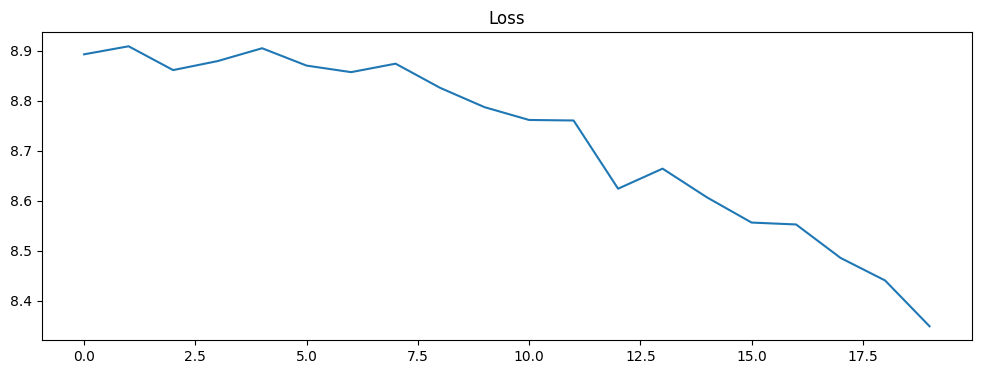

In [3]:
plt.figure(figsize=(12, 4))
plt.plot(losses)
plt.title('Loss')
plt.show()

In [4]:
# Cross-entropy ~3.5 corresponds to perplexity exp(3.5) ≈ 33. That can be “fine” or “terrible” depending on:
#	•	how many tokens are actually plausible at each step (if only ~tens are plausible, 33 is not crazy),
print(losses[-1], np.exp(losses[-1]))

8.349271774291992 4227.101338151152


## Autoregressive rollout
* Feed in test_tokens context window (same context +1 out)
* Generate one new token, add to context, adhere to grammar
* When a new full sparse frame is complete, [BOS, CH+DATA.., EOS], we make a new row
* Stop when we have stepped block_size (context window size)
* We should now have a dataframe of new deltas

TODO A later test would be to make new test_tokens with minimal columns and see if the model propose covariates.

In [5]:
rng_key = jax.random.PRNGKey(128)

In [6]:
rng_key, subkey = jax.random.split(rng_key)
max_new_tokens = 480  # number of tokens to predict
t_batch = int(block_size / n_channels) 
t = int(jax.random.randint(rng_key, shape=(), minval=0, maxval=len(X)-(3*t_batch)))

# Select a random batch (t)
X_test = X.iloc[t:t+t_batch] 
Y_test = X.iloc[t+t_batch:t+t_batch+t_batch]

# Pre-process it
X_test_normalized = (X_test-mu)/sigma
X_test_normalized = X_test_normalized.diff().dropna()
X_test_nv = X_test_normalized.values.astype(np.float32)   # (N, D)

# Pre-process future
Y_test_normalized = (Y_test-mu)/sigma
Y_test_normalized = Y_test_normalized.diff().dropna()
Y_test_nv = Y_test_normalized.values.astype(np.float32)   # (N, D)

# Discretize
X_test_tok = discretize.encode_asinh_global(jnp.asarray(X_test_nv), edges, s=s)
Y_test_tok = discretize.encode_asinh_global(jnp.asarray(Y_test_nv), edges, s=s)
test_tokens = tokenizer.encode_with_channels_sparse(X_test_tok, n_channels, zero_bin)
token_stream = test_tokens[-block_size:] # B, T

# Inspect first few tokens
print("Number of tokens:", len(test_tokens))
print("Number of tokens in stream:", len(token_stream))
print("Context window:", block_size)
print("Last context tokens:", token_stream)

Number of tokens: 924
Number of tokens in stream: 480
Context window: 480
Last context tokens: [2205    1    0    2 2159    3 2108    4 2051    5 1939    6 2020    7
 1789    8 2117    1    0    2 2148    3 2118    4 2182    5 2158    7
 2222    8 2027    1    0    2 2031    3 2168    4 2006    5 1759    6
 2020    7 1892    8 2051    1    0    2 1993    3 2158    4 2114    5
 1956    6 2132    7 1892    8 1938    1    0    2 1885    3 2148    4
 2287    5 2275    6 2169    8 1885    1    0    2 2056    3 2198    4
 1876    5 1591    6 1908    7 2222    8 2051    1    0    2 2045    3
 2108    4 1944    5 1791    6 1799    8 1997    1    0    2 2055    3
 2017    4 2182    5 2275    6 2020    7 2193    8 1944    1    0    2
 2149    3 2047    4 2080    5 2108    6 2132    8 2158    1    0    2
 2046    3 1956    4 2051    5 2225    6 2094    7 1761    8 2117    1
    0    2 2027    3 1966    4 2091    5 2275    6 1206    7 1663    8
 2015    1    0    2 1910    3 2017    4 2091    5 21

In [7]:
pd.DataFrame(Y_test_tok)

,0,1,2,3,4,5,6
0,1923,1977,1980,2065,1064,1780,2202
1,1899,1897,1867,2031,2048,2048,2167
2,1966,1967,1991,2116,2048,2048,2012
3,1973,2057,2074,2079,2048,2048,1994
4,2609,1998,2056,2169,2048,2048,1983
...,...,...,...,...,...,...,...
62,2383,2058,2082,2099,2048,2344,2024
63,2213,2119,2161,2116,2123,1883,2155
64,2138,2249,2273,2048,2011,2048,1929
65,2081,2278,2223,1896,2011,2213,1824


In [8]:
rng_key, subkey = jax.random.split(rng_key)
#token_stream_padded = inference.pad_tokens(token_stream)

#new_tokens = inference.generate_continue(
#    variables,
#    model.apply,
#    token_stream=token_stream_padded,
#    rng_key=rng_key,
#    vocab_size=vocab_size,
#    block_size=block_size,
#    max_new_tokens=max_new_tokens,
#    n_channels=n_channels,
#)


In [9]:
## Autoregressive rollout with covariates
# * Specify covariates values

cov_present, cov_value, cov_channels = inference.preprocess_covariates_from_future_matrix(
    future_tokens=Y_test_tok, 
    covariate_cols=[1, 2],
    zero_bin=zero_bin,
)

DATA_OFFSET = 2 + n_channels
cov_value_tokens = jnp.asarray(Y_test_tok, dtype=jnp.int32) + DATA_OFFSET  # (H, n_channels)

In [10]:
new_tokens = inference.generate_covariate_frames(
    variables, model.apply, token_stream, rng_key,
    vocab_size=vocab_size,
    block_size=block_size,
    #max_new_tokens=max_new_tokens,
    n_channels=n_channels,
    cov_value_tokens=cov_value_tokens,
    covariate_channels=jnp.asarray(cov_channels),
    n_frames=32, #t_batch#Y_test_tok.shape[0],    # or whatever horizon you want (STATIC!)
    zero_bin=zero_bin,
)

In [11]:
# Convert from stream to channel matrix
#tokens_padded = inference.pad_tokens(new_tokens)
rows, n = inference.decode_with_channels_stream(new_tokens, n_channels, zero_bin)
new_Y_tok = rows[:n]
new_Y_tok

Array([[2410, 1977, 1980, 2410, 2410, 2410, 2410],
       [ 694, 1897, 1867, 2410, 2410,  694, 2410],
       [2410, 1967, 1991, 2410, 2410, 2410, 2410],
       [2410, 2057, 2074, 2410, 2410, 2410, 2410],
       [2410, 1998, 2056,  694, 2410, 2171, 2410],
       [2410, 1987, 2025, 2410,  694, 2410, 2410],
       [2410, 2048, 2048, 2410, 2410, 2410, 2171],
       [2410, 2048, 2048, 2410, 2410, 2410, 2410],
       [2410, 2048, 2048,  694, 2410, 2410, 2410],
       [2171, 2088, 2042, 2410, 2410, 2410, 2410],
       [2410, 2048, 2048, 2171,  694, 2410, 2410],
       [2410, 2008, 2054, 2171, 2410, 2410, 2410],
       [ 694, 2068, 2003,  694,  694, 2410,  694],
       [2171, 2048, 2048,  694, 2410, 2410, 2171],
       [2171, 2078, 2150,  694, 2171, 2171, 2171],
       [2410, 2179, 1980, 2171, 2171,  694, 2410],
       [2410, 2149, 1935, 2410, 2410, 2410, 2410],
       [2410, 2169, 2122,  694, 2410,  967, 2410],
       [2410, 2159, 2065, 2410, 2410, 2410, 2410],
       [ 694, 2149, 1935, 2410,

In [12]:
print("expected:", Y_test_tok[:10, 1], Y_test_tok[:10, 2])
print("got:     ", new_Y_tok[:10, 1],  new_Y_tok[:10, 2])

expected: [1977 1897 1967 2057 1998 1987 2048 2048 2048 2088] [1980 1867 1991 2074 2056 2025 2048 2048 2048 2042]
got:      [1977 1897 1967 2057 1998 1987 2048 2048 2048 2088] [1980 1867 1991 2074 2056 2025 2048 2048 2048 2042]


Delta model, so mu is not added back

$$
\frac{(x_t - \mu) - (x_{t-1} - \mu)}{\sigma}
\quad\equiv\quad
\frac{x_t - x_{t-1}}{\sigma}
$$

Issues:
* Scale mismatch at inference, σ during training ≠ σ during rollout
* equal-width bins in z-space: Most mass lives in a tiny central region and many bins are effectively unused
* root cause is biased delta quantization + cumulative summation, not model capacity.

In [13]:
cols = X_test_normalized.columns
start = t + t_batch

# Decode tokens to deltas, cumsum with initial value, and de-normalize
Y_rec = discretize.decode_asinh_global(new_Y_tok, mids, s=s)
Y_rec = pd.DataFrame(Y_rec, columns=cols)
Y_rec = Y_rec * sigma # delta model so mu is not added back

#init_values = X_test.iloc[-1].values
init_values = X.iloc[start].values
Y_pred = init_values + jnp.cumsum(Y_rec.values, axis=0)
Y_pred = Y_pred
Y_test = X.iloc[start+1:start+1+len(Y_rec)]
Y_pred = pd.DataFrame(Y_pred, columns=cols, index=Y_test.index)
#Y_pred

In [37]:
#Y_test

In [17]:
visualization.plot_actual_vs_pred(Y_test, Y_pred, col_idx=0).render_notebook()

## Autoregressive channel hinter

Lets mask away some channels and see if the model hints about the missing channels.

In [ ]:
rng_key, subkey = jax.random.split(rng_key)
max_new_tokens = 480
t = int(jax.random.randint(rng_key, shape=(), minval=0, maxval=len(X)-(3*max_new_tokens)))

# Select a random batch (t)
X_test = X.iloc[t:t+max_new_tokens]
Y_test = X.iloc[t+max_new_tokens:t+max_new_tokens+max_new_tokens].reset_index(drop=True)

# Pre-process it
X_test_normalized = (X_test-mu)/sigma
X_test_normalized = X_test_normalized.diff().dropna()

# Mask out channel 1, 4->
n_cols = X_test_normalized.shape[1]
mask = np.ones(n_cols, dtype=bool)
mask[[1]] = False
mask[2:] = False

X_masked = X_test_normalized.copy()
X_masked.loc[:, ~mask] = 0

X_masked_nv = X_masked.values.astype(np.float32)   # (N, D)

# Discretize
X_masked_tok = discretize.encode_asinh_global(jnp.asarray(X_masked_nv), edges, s=s)
masked_tokens = tokenizer.encode_with_channels_sparse(X_masked_tok, n_channels, zero_bin)
masked_stream = masked_tokens[-block_size:] # B, T

# Inspect first few tokens
print("Number of tokens:", len(masked_tokens))
print("Number of tokens in stream:", len(masked_stream))
print("Context window:", block_size)
print("Last context tokens:", masked_stream)

In [ ]:
X_masked

In [ ]:
masked_stream_padded = inference.pad_tokens(masked_stream)
new_masked_tokens = inference.generate_continue(
    variables,
    model.apply,
    token_stream=masked_stream_padded,
    rng_key=rng_key,
    vocab_size=vocab_size,
    block_size=block_size,
    max_new_tokens=max_new_tokens,
    n_channels=n_channels,
)

In [ ]:
# Convert from sparse stream to all channel matrix
new_masked_tokens_padded = inference.pad_tokens(new_masked_tokens)
rows, n = inference.decode_with_channels_stream(new_masked_tokens_padded, n_channels)
new_masked_tok = rows[:n]
new_masked_tok

In [ ]:
# Decode tokens to deltas, cumsum with initial value, and de-normalize
Y_masked_rec = discretize.decode_asinh_global(new_masked_tok, mids, s=s)
Y_masked_rec = pd.DataFrame(Y_masked_rec, columns=X.columns)
Y_masked_rec = Y_masked_rec * sigma # delta model so mu is not added back

pd.DataFrame(Y_masked_rec)

In [ ]:
# Cumsum
init_values = X_test.iloc[-1].values
Y_masked_pred = init_values + jnp.cumsum(Y_masked_rec.values, axis=0)

Y_test = X.iloc[t+max_new_tokens:t+max_new_tokens+len(Y_masked_pred)]
Y_masked_pred = pd.DataFrame(Y_masked_pred, columns=X.columns, index=Y_test.index)

Y_masked_pred

In [ ]:
col = 'Power demand'
#col = 'temp'
plt.figure(figsize=(12, 4))
plt.plot(Y_test.index, Y_test[col], label="Actual")
plt.plot(Y_masked_pred.index, Y_masked_pred[col], label="Predicted")
plt.title('Predicted vs actual')
plt.legend()
plt.show()